In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
import statsmodels.formula.api as smf
from pandas import read_csv
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression



%matplotlib inline

train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
items_categories = pd.read_csv('dataset/item_categories.csv')

def preprocess_date(data):
    data['date'], data['month'], data['year'] = data['date'].str.split('.').str
    data[['date']] = data[['date']].astype(int)
    data[['month']] = data[['month']].astype(int)
    data[['year']] = data[['year']].astype(int)
    return data

print(preprocess_date(train).head())




   date  date_block_num  shop_id  item_id  item_price  item_cnt_day  month  \
0     2               0       59    22154      999.00           1.0      1   
1     3               0       25     2552      899.00           1.0      1   
2     5               0       25     2552      899.00          -1.0      1   
3     6               0       25     2554     1709.05           1.0      1   
4    15               0       25     2555     1099.00           1.0      1   

   year  
0  2013  
1  2013  
2  2013  
3  2013  
4  2013  


In [111]:
from collections import Counter

def groupby_dbn_shopid_item(data):
    month_sales = data.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
    return month_sales

def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)


def get_monthlysales_by_itemid(data, itemid):
    select_by_item = data[data["item_id"]==itemid]
    monthlysales_group = select_by_item.groupby(["date_block_num"])
    monthlysales = (monthlysales_group[["item_cnt_day"]].sum().reset_index())
    monthlysales = monthlysales.rename(columns={ "item_cnt_day": "item_cnt_month" })
    #fill date_block_num
    listdata = [i for i in range(34)]
    #new_data = pd.DataFrame(columns = ["date_block_num", "item_cnt_month"])
    new_data = pd.DataFrame(listdata, columns=['date_block_num'])
    new_data = pd.merge(new_data, monthlysales, how='outer')
    result = new_data.fillna(0)
    return result


data = train
c = Counter(data["item_id"])

monthlysales = get_monthlysales_by_itemid(data, 5527)

print(monthlysales)

    date_block_num  item_cnt_month
0                0             3.0
1                1             2.0
2                2             1.0
3                3             4.0
4                4             2.0
5                5             2.0
6                6             4.0
7                7             4.0
8                8             2.0
9                9             1.0
10              10             5.0
11              11             1.0
12              12             0.0
13              13             0.0
14              14             0.0
15              15             1.0
16              16             0.0
17              17             0.0
18              18             0.0
19              19             2.0
20              20             0.0
21              21             0.0
22              22             0.0
23              23             0.0
24              24             0.0
25              25             0.0
26              26             0.0
27              27  

[3. 2. 1. 4. 2. 2. 4. 4. 2. 1. 5. 1. 0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2475      0.584     -0.424      0.672      -1.391       0.896
ma.L1         -1.0000   7797.678     -0.000      1.000   -1.53e+04    1.53e+04
ar.S.L12       0.1492      0.076      1.959      0.050   -9.43e-05       0.298
sigma2         0.1617   1260.776      0.000      1.000   -2470.914    2471.237


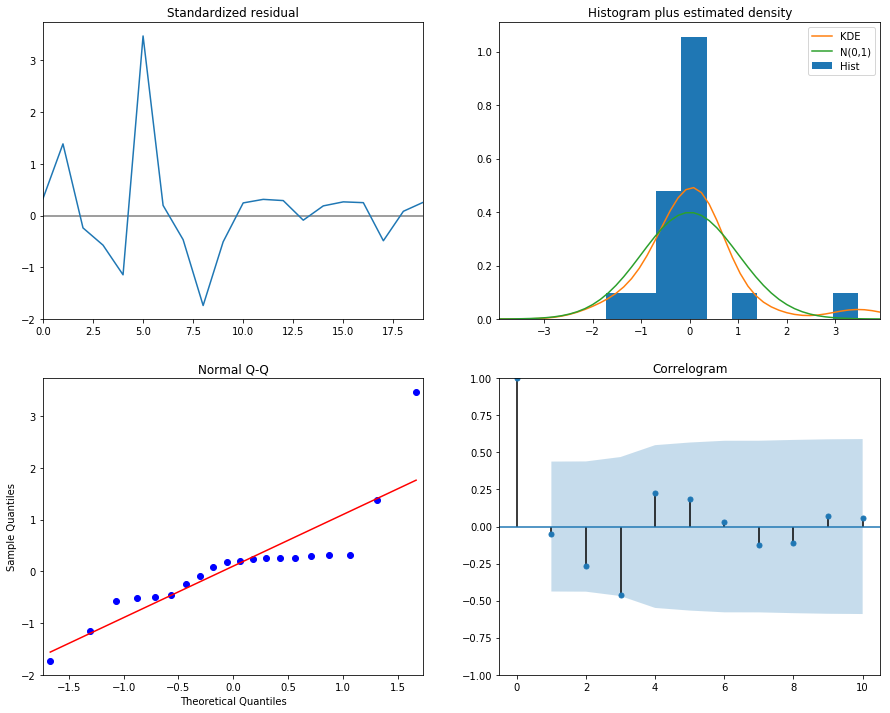

[-0.10172953]


In [122]:
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



def arima_predict(data):
    '''
    data = pd.DataFrame(data)
    acf = plot_acf(data,lags=20)
    pacf = plot_pacf(data,lags=20)
    for i in range(3):
        data_diff = data.diff(1)
        diff = data.dropna()
    plt.figure()
    plt.plot(diff)
    '''
    
    select_data = data["item_cnt_month"].values
    print(select_data)
    mod = sm.tsa.statespace.SARIMAX(select_data,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 0, 0, 12),
                                    max_lag=4,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    pred = results.get_prediction(10, dynamic=False)
    pred_ci = pred.conf_int()
    #print(pred_ci.shape)
    print((results.forecast(1)))
    return 

dta=[10930,10318,10595,10972,7706,6756,9092,10551,9722,10913,11151,8186,6422,
6337,11649,11652,10310,12043,7937,6476,9662,9570,9981,9331,9449,6773,6304,9355,
10477,10148,10395,11261,8713,7299,10424,10795,11069,11602,11427,9095,7707,10767,
12136,12812,12006,12528,10329,7818,11719,11683,12603,11495,13670,11337,10232,
13261,13230,15535,16837,19598,14823,11622,19391,18177,19994,14723,15694,13248,
9543,12872,13101,15053,12619,13749,10228,9725,14729,12518,14564,15085,14722,
11999,9390,13481,14795,15845,15271,14686,11054,10395]

#arima_predict(dta)

arima_predict(monthlysales)